# Unit 7.4: Training Convolutional Neural Networks

## Part 2 of 5: Swapping the MLP for an CNN to classify MNIST images



In [1]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel, MnistDataModule, plot_loss_and_acc

In [2]:
L.pytorch.seed_everything(123)

dm = MnistDataModule(batch_size=64)
dm.prepare_data()
dm.setup()

Global seed set to 123


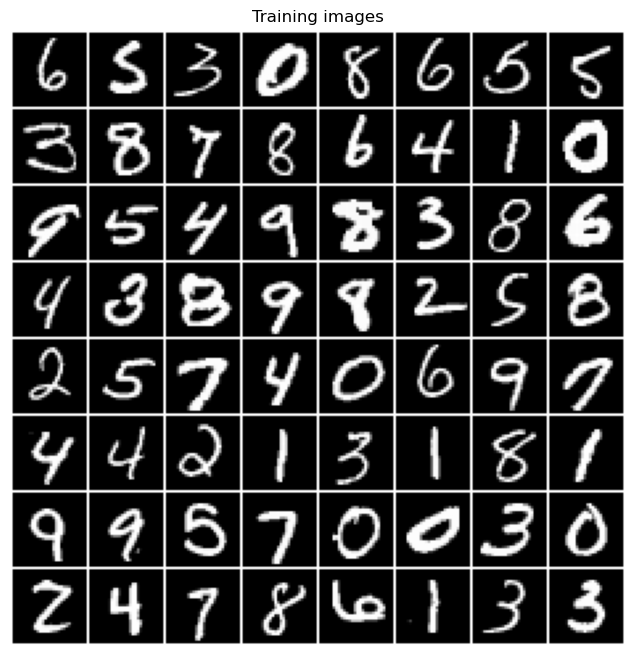

In [3]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))

plt.show()

In [5]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.BatchNorm1d(50),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [4]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.cnn_layers = torch.nn.Sequential(
            # input 1x28x28
            torch.nn.Conv2d(1, 3, kernel_size=5),
            # [28-5+1] = 3*24*24
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # when we don't specify stride, it's the same as kernel_size
            # output 3x12x12 [(24-2)/2 + 1]
            
            torch.nn.Conv2d(3, 16, kernel_size=3),
            # [12 - 3 + 1] = 16*10*10
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),        
            # output 16x5x5 [(10-2)/2 + 1]
            
            torch.nn.Conv2d(16, 32, kernel_size=3),
            # [5 - 3 + 1] = 32*3*3
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), 
            # output 32x1x1 [(3-2)/2 + 1]
        )
        
        self.fc_layers = torch.nn.Sequential(
            # hidden layer
            torch.nn.Linear(32, 20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc_layers(x)
        return logits

In [6]:
# %%capture --no-display

L.seed_everything(123)
dm = MnistDataModule()

pytorch_model = PyTorchCNN(num_classes=10)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Global seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=lightning_model, datamodule=dm)

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my-model/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchCNN         | 6.2 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/my-model/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 859/859 [00:14<00:00, 58.37it/s, v_num=0, val_loss=0.0532, val_acc=0.984, train_acc=0.988]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 859/859 [00:14<00:00, 58.35it/s, v_num=0, val_loss=0.0532, val_acc=0.984, train_acc=0.988]


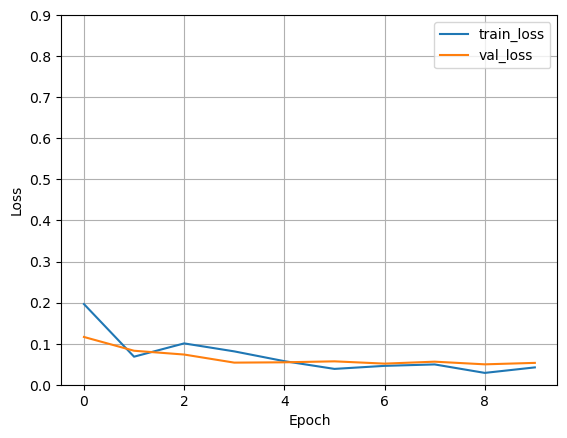

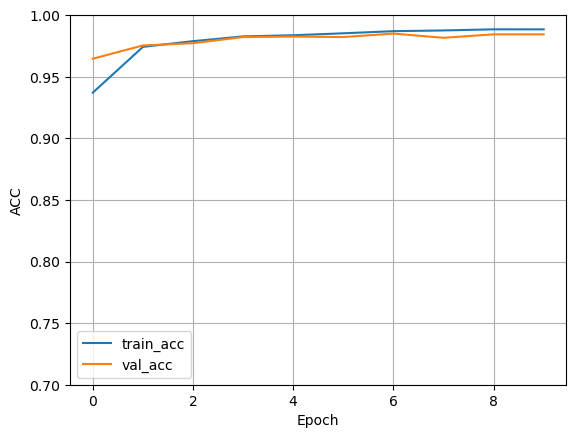

In [8]:
plot_loss_and_acc(trainer.logger.log_dir)

In [9]:
trainer.test(model=lightning_model, datamodule=dm)

/Users/alimtleuliyev/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 118.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.984000027179718     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.984000027179718}]